## Build a spam classifier (a more challenging exercise)
• Download examples of spam and ham from Apache SpamAssassin’s public
datasets.

• Unzip the datasets and familiarize yourself with the data format.

• Split the datasets into a training set and a test set.

• Write a data preparation pipeline to convert each email into a feature vector.

Your preparation pipeline should transform an email into a (sparse) vector
indicating the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.

• You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).

• Then try out several classifiers and see if you can build a great spam classifier,
with both high recall and high precision.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
import os
import re
from pathlib import Path

In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import base
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
easy_ham = Path("./AssassinSpam/easy_ham")
easy_ham_2 = Path("./AssassinSpam/easy_ham_2")
hard_ham = Path("./AssassinSpam/hard_ham")
spam = Path("./AssassinSpam/spam")
spam_2 = Path("./AssassinSpam/spam_2")

In [7]:
def creating_df(path):
    
    list_emails = []
    
    for files in os.listdir(path):
        
        file = open(path/files,"r",encoding="latin-1")
        
        list_emails.append(file.read())
        
        file.close()
        
    df = pd.DataFrame(list_emails,columns=["emails"])    
    
    if "ham" in path.name:
        df["spam_ham"] = "ham"
    else:
        df["spam_ham"] = "spam"
    
    return df

In [8]:
df_spam = creating_df(spam)
df_spam_2 = creating_df(spam_2)
df_hard_ham = creating_df(hard_ham)
df_easy_ham = creating_df(easy_ham)
df_easy_ham_2 = creating_df(easy_ham_2)

In [9]:
df = pd.concat([df_spam_2,df_spam],sort=False)
df = pd.concat([df,df_hard_ham],sort=False)
df = pd.concat([df,df_easy_ham_2],sort=False)
df = pd.concat([df,df_easy_ham],sort=False)

ham     69.0
spam    31.0
Name: spam_ham, dtype: float64


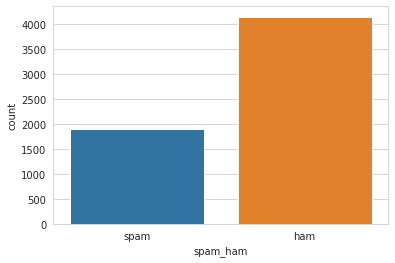

In [10]:
print(np.round(df["spam_ham"].value_counts() / len(df) *100))
sns.countplot(x="spam_ham",data=df)

So we have a proportion of 31% of Spam and 69% of ham emails.

In [11]:
X = df.drop(columns=["spam_ham"])
y = df["spam_ham"]

In [12]:
#Split the datasets into a training set and a test set.
#X_train,y_train,X_test,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [13]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(X,y):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [14]:
strat_train_set

,emails,spam_ham
311,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,spam
297,From ilug-admin@linux.ie Mon Aug 19 12:30:37 ...,ham
636,From vjli_Jbfun8575@mail.com Thu Jul 18 03:08...,spam
116,From ly9qowv6r47@hotmail.com Mon Jun 24 17:05...,spam
1751,From fork-admin@xent.com Tue Aug 27 11:06:58 ...,ham
804,From exmh-users-admin@redhat.com Fri Sep 13 1...,ham
2068,From rpm-list-admin@freshrpms.net Mon Sep 30 ...,ham
1789,Return-Path: guido@python.org\nDelivery-Date: ...,ham
1070,From ilug-admin@linux.ie Tue Aug 13 10:30:49 ...,ham
425,From paige_455@aol.com Sun Sep 22 14:13:09 20...,spam


In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [ ]:
nlp_pipeline =  Pipeline([
                #remove unwanted elements from out data like symbols and numbers
                ("countvectorizer",CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize))
                ])

In [ ]:
Feature_selection = Pipeline([
    ('Rf',RandomForestClassifier(n_jobs=-1,random_state=42))
                            ])

In [ ]:
model_pipeline = Pipeline([
    ('transformation_pipeline',nlp_pipeline),
    ('Feature_selection',Feature_selection)])

In [ ]:
#Preparing fata for the first machine learning algorithm

spam_ham = strat_train_set.drop("spam_ham",axis=1)
spam_ham_labels = strat_train_set["spam_ham"].copy()

In [ ]:
strat_train_set_prepared = nlp_pipeline.fit_transform(spam_ham["emails"])

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
score = cross_val_score(Feature_selection,strat_train_set_prepared,spam_ham_labels,cv=3,scoring="accuracy")

In [ ]:
np.mean(score)

In [ ]:
#Preparing fata for the first machine learning algorithm

spam_ham_test = strat_train_set.drop("spam_ham",axis=1)
spam_ham_labels_test = strat_train_set["spam_ham"].copy()

In [ ]:
strat_test_set_prepared = nlp_pipeline.fit_transform(spam_ham_test["emails"])

In [ ]:
Feature_selection.fit(strat_train_set_prepared,spam_ham_labels)

In [ ]:
y_predict = Feature_selection.predict(strat_test_set_prepared)
spam_ham_labels_test = [1 if x =="spam" else 0 for x in spam_ham_labels_test]
y_predict = [1 if x =="spam" else 0 for x in y_predict]

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,\
                            precision_score,precision_recall_curve,\
                            confusion_matrix,recall_score,\
                            classification_report,f1_score

#Using the Sklearn visualization API...
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall,plot_roc_curve

In [ ]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.figure(figsize=(12,8))
    plt.plot(fpr,tpr,linewidth = 2,label=label)
    plt.plot([0,1],[0,1],"k--") #Dashed diagonal
    plt.ylabel("True Positive Rate (FPR) / Recall / Sensitivity")
    plt.xlabel("True Negative Rate (FPR) /1- Specificity")
    plt.legend()
    
def print_metrics(predicted_y,y_test):
    
    fpr , tpr, thresholds = roc_curve(predicted_y,y_test)
    
    plot_roc_curve(fpr , tpr)
    plt.show()
    
    print(f"The area under the roc curve is {roc_auc_score(predicted_y,y_test)}")
    
   
    print("\n")
    print(f"Accuracy Score : {(accuracy_score(predicted_y,y_test))}")
    print(f"Precision Score : {(precision_score(predicted_y,y_test))}")
    print(f"Recall Score : {(recall_score(predicted_y,y_test))}")
    print(f"F1 Score : {(f1_score(predicted_y,y_test))}")
    print("\n")
    print(plot_confusion_matrix(predicted_y,y_test))
    print(f"{classification_report(predicted_y,y_test)}")

In [ ]:
print_metrics(y_predict,spam_ham_labels_test)